# vector data

## 1. Import geometry data

In [1]:
# !pip install h3-toolkit, geopandas, polars, psycopg2-binary, sqlalchemy, geoalchemy2, connectorx

In [1]:
import os

import geopandas as gpd
import polars as pl
from dotenv import load_dotenv
from sqlalchemy import create_engine

load_dotenv()
URI = os.getenv("POSTGRES")


### 1.1. Use `geopandas` to fetch vector data from Postgis (slowly)  
*CSL researcher only*

In [2]:
sql = """
with boundary as (
    select 代碼, geometry
    from geometry.boundary_smallest
    where 縣市代碼 = %(city_code)s
)
select aps.*, boundary.geometry as geometry
from geometry.af_ppl_stats as aps
join boundary
on aps.codebase = boundary.代碼
"""

engine = create_engine(URI)
with engine.connect() as conn:
    gdf = gpd.read_postgis(
        sql,
        con=conn.connection,
        geom_col='geometry',
        params={'city_code': '63000'} # 台北市
    )

/Users/syuanbo/Documents/Project/h3-aggregation/.venv/lib/python3.10/site-packages/geopandas/io/sql.py:185: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(
/Users/syuanbo/Documents/Project/h3-aggregation/.venv/lib/python3.10/site-packages/geopandas/io/sql.py:473: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(spatial_ref_sys_sql, con)


In [3]:
gdf.head()

,codebase,city,h_cnt,p_cnt,m_cnt,f_cnt,info_time,geometry
0,A6301-0053-00,臺北市,93,221,95,126,2023-12-01 00:00:00+00:00,"MULTIPOLYGON (((121.54629 25.06331, 121.54723 ..."
1,A6301-0003-00,臺北市,13,22,9,13,2023-12-01 00:00:00+00:00,"MULTIPOLYGON (((121.55699 25.07261, 121.55697 ..."
2,A6301-0004-00,臺北市,0,0,0,0,2023-12-01 00:00:00+00:00,"MULTIPOLYGON (((121.55222 25.07344, 121.55541 ..."
3,A6301-0005-00,臺北市,1,2,1,1,2023-12-01 00:00:00+00:00,"MULTIPOLYGON (((121.55106 25.07226, 121.55152 ..."
4,A6301-0006-00,臺北市,10,21,12,9,2023-12-01 00:00:00+00:00,"MULTIPOLYGON (((121.5549 25.07218, 121.55671 2..."


### 1.2. Use `polars+connectorx` to fetch vector data from Postgis (faster, recommended)
*CSL researcher only*

In [4]:
city_code = 63000

sql = f"""
with boundary as (
    select 代碼, geometry
    from geometry.boundary_smallest
    where 縣市代碼 = {city_code}
)
select aps.*, ST_AsBinary(boundary.geometry) as geometry_wkb
from geometry.af_ppl_stats as aps
join boundary
on aps.codebase = boundary.代碼
"""

pdf = pl.read_database_uri(sql, URI, engine="connectorx")
pdf.head()


codebase,city,h_cnt,p_cnt,m_cnt,f_cnt,info_time,geometry_wkb
str,str,i64,i64,i64,i64,"datetime[ns, UTC]",binary
"""A6301-0053-00""","""臺北市""",93,221,95,126,2023-12-01 00:00:00 UTC,"b""\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00R\xad\xfd^\xf6b^@\xacQ4f5\x109@\xc8\xc0\x80\xd8\x05c^@\xc1\xa9Wt4\x109@0B\xa6l\xfeb""..."
"""A6301-0054-00""","""臺北市""",14,27,15,12,2023-12-01 00:00:00 UTC,"b""\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x05\x00\x00\x000B\xa6l\xfeb^@_n\x09;\x15\x109@\xc8\xc0\x80\xd8\x05c^@\xc1\xa9Wt4\x109@\xa8\x09\xc3\xfe\x0fc""..."
"""A6301-0057-00""","""臺北市""",59,137,70,67,2023-12-01 00:00:00 UTC,"b""\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x07\x00\x00\x00%\xb7\x1e\x1d\xeeb^@\xfa\x20g\xef\x15\x109@/Y\x9eP\xeeb^@\x85\x91\xcb\xf9'\x109@G\xd3\xfa>\xf6b""..."
"""A6301-0063-00""","""臺北市""",63,156,80,76,2023-12-01 00:00:00 UTC,"b""\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x0c\x00\x00\x00\xb4\xb8\xb35\xd5b^@\xdd\x17*W7\x109@@\xe7=\x94\xd7b^@L\xa0`W7\x109@\x15\xa4>\xc4\xe0b""..."
"""A6301-0067-00""","""臺北市""",313,765,348,417,2023-12-01 00:00:00 UTC,"b""\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03\x00\x00\x00\x01\x00\x00\x00\x08\x00\x00\x00\xe6A5\xa4\xe0b^@\x06\xc4\xf3\x8b\x16\x109@!\xc5\xd2\xd6\xedb^@\xce\x06}\xf2\x15\x109@%\xb7\x1e\x1d\xeeb""..."


### 1.3. Use `geopandas` to read geometry file

<Axes: >

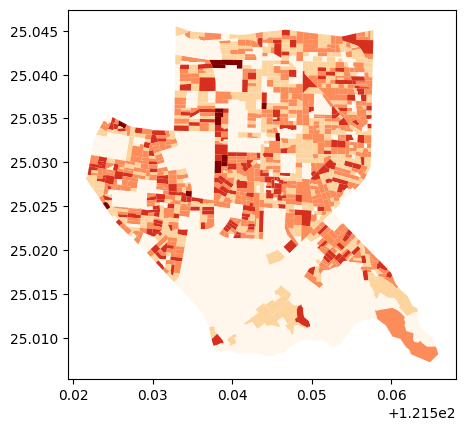

In [2]:
data = gpd.read_file('data/test_geom.geojson')
data.plot(column='p_cnt',
               cmap='OrRd',         # 使用顏色映射
               scheme='naturalbreaks',  # 自然斷點分類
               k=5,
               legend=False
)

## 2. Geometry to h3

The `H3Toolkit` is a chainable class that can convert geometry data to h3 index.

- **Step1**: use `set_aggregation_strategy()` to set the target column and the aggregation method in the dict `{ column_name : aggregation_function() }`.
- **Step2**: use `process_from_vector()` to set the data and the h3 resolution, this function will convert the geometry to h3 index in the designated resolution and process the column(s) with the aggregation method you set.
- **Step3**: use `get_result()` to get the result. default is a polars dataframe with the h3 index and the aggregated column(s), if you want the actual geometry, you can set `return_geometry=True` to get the geometry column, and the return type will be the geopandas dataframe.


NOTE: this function always use the centroid of the h3 hexagon to extract the data from actual geometry object, so the result may loss some information if you choose the inproper resolution. If missing data exists, the warnging will be raised. you should choose the proper resolution to avoid this situation, ie from resolution 7 to 10. if you want the lower resolution, you can chain the result from `process_from_vector()` to `process_from_h3()` to get the lower resolution h3 index without lossing any information.

must to use `get_result()` to get the result, otherwise return will be the H3Toolkit object.

In [3]:
from h3_toolkit import H3Toolkit
from h3_toolkit.aggregation import SplitEqually

toolkit = H3Toolkit()

result = (
    toolkit
    .set_aggregation_strategy(
        {
            'p_cnt' : SplitEqually(agg_col='codebase'),
        }
    )
    .process_from_vector(data, resolution=12, geometry_col='geometry')
)

output_df = result.get_result()

output_df.head()

hex_id,p_cnt
str,f64
"""8c4ba0a412a01ff""",14.208333
"""8c4ba0a412a05ff""",14.208333
"""8c4ba0a412a07ff""",14.208333
"""8c4ba0a412a09ff""",14.208333
"""8c4ba0a412a0bff""",14.208333


set `return_geometry=True` to get the geometry column in the result.

In [4]:
output_gdf = result.get_result(return_geometry=True)
output_gdf.head()

,hex_id,p_cnt,geometry
0,8c4ba0a412a01ff,14.208333,"POLYGON ((121.54706 25.04487, 121.54705 25.044..."
1,8c4ba0a412a05ff,14.208333,"POLYGON ((121.54695 25.04474, 121.54694 25.044..."
2,8c4ba0a412a07ff,14.208333,"POLYGON ((121.54713 25.04473, 121.54711 25.044..."
3,8c4ba0a412a09ff,14.208333,"POLYGON ((121.547 25.04501, 121.54698 25.04492..."
4,8c4ba0a412a0bff,14.208333,"POLYGON ((121.54717 25.045, 121.54716 25.04491..."


## 3. Scale current h3 resolution to the target resolution

scale up the h3 index to the target resolution, the `process_from_h3()` function will do this job.

NOTE: The `source_resolution` must be greater than the `target_resolution`, otherwise the result will be wrong.

In [5]:
from h3_toolkit import H3Toolkit
from h3_toolkit.aggregation import SumUp

toolkit = H3Toolkit()

result = (
    toolkit
    .set_aggregation_strategy(
        {
            'p_cnt' : SumUp(),
        }
    )
    .process_from_h3(
        output_df,
        source_resolution=12,
        target_resolution=10,
        h3_col='hex_id'
    )
)

output_df_10 = result.get_result()
output_df_10.head()

hex_id,p_cnt
str,f64
"""8a4ba0a4065ffff""",774.677778
"""8a4ba0a430b7fff""",907.310419
"""8a4ba0a4e937fff""",229.645577
"""8a4ba0a43897fff""",496.65652
"""8a4ba0a5da37fff""",534.311858


Now, you are successfully scale up the data from resolution 12 to 10.

The benefit of H3Toolkit is that you can chain all the functions together, it's much simple and maintainable. and make the process logic more clear!

In [6]:
toolkit = H3Toolkit()

result = (
    toolkit
    .set_aggregation_strategy(
        {
            ('p_cnt', 'h_cnt') : SplitEqually(agg_col='codebase'),
        }
    )
    .process_from_vector(data, resolution=12, geometry_col='geometry')
    .set_aggregation_strategy(
        {
            ('p_cnt', 'h_cnt') : SumUp(),
        }
    )
    .process_from_h3(
        source_resolution=12,
        target_resolution=10,
        h3_col='hex_id'
    )
    .get_result()
)

result.head()

hex_id,p_cnt,h_cnt
str,f64,f64
"""8a4ba0a43027fff""",603.92619,204.539286
"""8a4ba0a41757fff""",235.163073,115.281683
"""8a4ba0a43a27fff""",537.958196,220.011264
"""8a4ba0a431a7fff""",2.648649,0.993243
"""8a4ba0a5db0ffff""",351.518243,152.070146


### Store data in parquet format
- Why parquet?

## 4. Visualization
There are some packages can let you visualize the h3 data without converting it to the geometry object, such as `keplergl` and `pydeck`. This example will show you how to use `pydeck` to visualize the h3 data.

In [7]:
import mapclassify as mc
import pandas as pd
import pydeck as pdk
from matplotlib import colormaps

INITIAL_VIEW_STATE = {
    'latitude':25.0307167767897,
    'longitude':121.5359704226339,
    'zoom':13,
    'max_zoom':16,
    'pitch':0,
    'bearing':0
}

In [8]:
def _set_color(
    data:pl.DataFrame | gpd.GeoDataFrame,
    target_col:str,
) -> pd.DataFrame | gpd.GeoDataFrame:
    """set color column for data based on target_col
    """

    # change this classifier to fit your data
    classifier = mc.NaturalBreaks(data[target_col], k=5)
    cmap = colormaps.get_cmap('Oranges')

    if isinstance(data, pl.DataFrame):
        data = data.to_pandas()
    data['interval'] = classifier.find_bin(data[target_col])
    data['color'] = data['interval'].apply(lambda x: cmap(x / data['interval'].max()))
    data['color'] = data['color'].apply(lambda c: [int(255 * i) for i in c[:3]] + [255])
    data = data.drop(columns='interval')

    return data


def show_h3(
    data:pl.DataFrame,
    target_col:str,
    h3_col='hex_id'
):
    """show h3 hexagon layer
    """

    data = data.clone()
    data = _set_color(data, target_col)
    data = data.to_dict(orient='records')

    layer_h3 = pdk.Layer(
        'H3HexagonLayer',
        data,
        get_fill_color='color',
        # get_line_color=[255, 255, 255],
        # get_elevation='p_cnt',
        get_hexagon=h3_col,
        pickable=True,
        opacity=0.4,
        stroked=False,
        filled=True,
        extruded=False,
    )

    r = pdk.Deck(
        layers=[layer_h3],
        initial_view_state=pdk.ViewState(**INITIAL_VIEW_STATE),
        tooltip={"text": f"{target_col}: {{{target_col}}}"}
    )
    return r

In [ ]:
show_h3(output_df, 'p_cnt')

Due to performance limitations when rendering large H3 datasets on the web, here’s a screenshot example of the visualization. For an interactive map, you can clone the notebook and run it locally in your environment


![res12](./img/01-1.png)

In [ ]:
show_h3(output_df_10, 'p_cnt')

Due to performance limitations when rendering large H3 datasets on the web, here’s a screenshot example of the visualization. For an interactive map, you can clone the notebook and run it locally in your environment


![res10](./img/01-2.png)

It's not recommended using `pydeck` or `kepler.gl` to visualize the h3 data if the data is too large, because the h3 data is too dense to visualize, it will be very slow and may crash.

The better way to visual large dataset is using `lonboard`, but this package is not support the h3 data yet, so you should convert the h3 data to the geometry data before visualizing it.

In [15]:
## TODO: Use case of lonborad

## 5. Customize the aggregation function

We provided some popular aggregation methods for doing the aggregation, read the `h3_toolkit.aggregation` class to get more information.

But you can also custom your specific aggregation function by yourself, just define a function that inherit from the `AggregationStrategy` class and implement the `apply()` function.


In [10]:
from h3_toolkit import H3Toolkit
from h3_toolkit.aggregation import AggregationStrategy


class NewAggregationStrategy(AggregationStrategy):
    """
    Make sure to inherit from AggregationStrategy and implement the apply method
    with data and target_cols attributes.
    """
    def __init__(self, new_var):
        """
        If you want to pass some parameters to the strategy, you can do it here.
        """
        self.new_var = new_var


    def apply(data:pl.DataFrame, target_cols:list[str]) -> pl.DataFrame:
        """
        If you are not familiar with polars, you can use pandas instead.
        just make sure to convert the type to polars dataframe before returning it.
        >>> data = data.to_pandas()
        >>> ...
        >>> ...
        >>> ...
        >>> return pl.from_pandas(data)
        """
        pass


toolkit = H3Toolkit()
toolkit.set_aggregation_strategy(
    {
        ('col_name', '...') : NewAggregationStrategy(new_var='...'),
    }
)